# DAT 490 Capstone Project
## Group 6
## Alex Kazepides, Jacob Trainor, and Benjamin Wilcox
## October 19, 2025

Important Libraries

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
import geopandas as gpd
from shapely.geometry import Point, Polygon
import numpy as np
import seaborn as sns
import plotly.express as px
import datetime


# U.S. Pollution Data 2000 - 2023
## Introduction

The main data set that we will be analyzing is the following data set, found on Kaggle:

https://www.kaggle.com/datasets/guslovesmath/us-pollution-data-200-to-2022

This data set is a collection of air pollution-based data that was originally taken from the U.S. Environmental Protection Agency. It has been condensed to provide key data on a select number of air pollutants, these being ozone (O3), carbon monoxide (CO), sulfur dioxide (SO2), and nitrogen dioxide (NO2) based on the air quality index (AQI). For each point of data, it also provides the date collected and the exact address, including the state, country, and city.

Here is a small snippet of the data for a clearer visualization.

In [ ]:
aqdf = pd.read_csv('/pollution_2000_2023.csv')
aqdf.head()

,Unnamed: 0,Date,Address,State,County,City,O3 Mean,O3 1st Max Value,O3 1st Max Hour,O3 AQI,...,CO 1st Max Hour,CO AQI,SO2 Mean,SO2 1st Max Value,SO2 1st Max Hour,SO2 AQI,NO2 Mean,NO2 1st Max Value,NO2 1st Max Hour,NO2 AQI
0,0,2000-01-01,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,0.019765,0.040,10,37,...,23,25.0,3.000000,9.0,21,13.0,19.041667,49.0,19,46
1,1,2000-01-02,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,0.015882,0.032,10,30,...,0,26.0,1.958333,3.0,22,4.0,22.958333,36.0,19,34
2,2,2000-01-03,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,0.009353,0.016,9,15,...,8,28.0,5.250000,11.0,19,16.0,38.125000,51.0,8,48
3,3,2000-01-04,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,0.015882,0.033,9,31,...,23,34.0,7.083333,16.0,8,23.0,40.260870,74.0,8,72
4,4,2000-01-05,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,0.007353,0.012,9,11,...,2,42.0,8.708333,15.0,7,21.0,48.450000,61.0,22,58


Here is a representation of what some of the data will look like. The different measurements for the different air pollutants are also shown and are defined from the data set's source. The mean of a pollutant is it's mean density in the air throughout an entire day. The 1st max value is the maximum density the pollutant reached in the span of one day. The 1st max hour is the hour in which the pollutant reached its highest density for the day. The AQI shows the AQI score for that day in regards to that pollutant.

We will be analyzing these data in both Arizona and the U.S. as a whole in order to find key patterns and give sufficient context to our future research plans.

## Data Munging and Cleaning

To make the data easier to sort through, the date variable will be separated into three different variables, one each for the year, month, and day.

In [ ]:
aqdf['date_dt'] = pd.to_datetime(aqdf['Date'])
aqdf['day'] = aqdf['date_dt'].dt.day
aqdf['month'] = aqdf['date_dt'].dt.month
aqdf['year'] = aqdf['date_dt'].dt.year
aqdf.head()

,Unnamed: 0,Date,Address,State,County,City,O3 Mean,O3 1st Max Value,O3 1st Max Hour,O3 AQI,...,SO2 1st Max Hour,SO2 AQI,NO2 Mean,NO2 1st Max Value,NO2 1st Max Hour,NO2 AQI,date_dt,day,month,year
0,0,2000-01-01,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,0.019765,0.040,10,37,...,21,13.0,19.041667,49.0,19,46,2000-01-01,1,1,2000
1,1,2000-01-02,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,0.015882,0.032,10,30,...,22,4.0,22.958333,36.0,19,34,2000-01-02,2,1,2000
2,2,2000-01-03,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,0.009353,0.016,9,15,...,19,16.0,38.125000,51.0,8,48,2000-01-03,3,1,2000
3,3,2000-01-04,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,0.015882,0.033,9,31,...,8,23.0,40.260870,74.0,8,72,2000-01-04,4,1,2000
4,4,2000-01-05,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,0.007353,0.012,9,11,...,7,21.0,48.450000,61.0,22,58,2000-01-05,5,1,2000


We will also need to clean our data, but keep a version of the data pre-cleaning in order to explore both facets.

In [ ]:
print("Pre-Cleaning Size:",aqdf.shape)
aqdfClean = aqdf.dropna()
print("Post-Cleaning Size:",aqdfClean.shape)

Pre-Cleaning Size: (665414, 26)
Post-Cleaning Size: (665414, 26)


As it turns out, even after visually scanning our data, there are no data points with any unknown values in this data set, making our analysis easier as we only need to analyze this one data set with no cleaning involved. One interesting note, however, is that some values in the City variable are listed as "Not in a city," which we may want to disaggregate later. Here is an example of a full row with this characteristic.

In [ ]:
print(aqdf.loc[[613369]])

        Unnamed: 0        Date                     Address         State  \
613369      613369  2021-03-05  NARSTO SITE - ARENDTSVILLE  Pennsylvania   

       County           City   O3 Mean  O3 1st Max Value  O3 1st Max Hour  \
613369  Adams  Not in a city  0.038706             0.039                7   

        O3 AQI  ...  SO2 1st Max Hour  SO2 AQI  NO2 Mean  NO2 1st Max Value  \
613369      36  ...                 0      0.0  0.782609                1.0   

        NO2 1st Max Hour  NO2 AQI    date_dt  day  month  year  
613369                 0        1 2021-03-05    5      3  2021  

[1 rows x 26 columns]


## Arizona Analysis

The target variables in this data set will be each of the variables that have to do with an air pollutant, such as SO2 Mean and CO AQI. The rest of the variables will be the features that we will use to analyze our target variables. These will be columns that describe the location or date of collection.

### Average AQI by Year

First, we will take a look at characteristics of the data in Arizona alone. Then, we will move on to analyzing the data in the U.S. as a whole. The AQI is a significant indicator of air pollution, as it determines its levels of danger, so we will start there. It should be noted from previous research, that the danger level indicated by AQI increases for every 50 points. Here is a plot that depicts the average AQI of each of the pollutants by year.

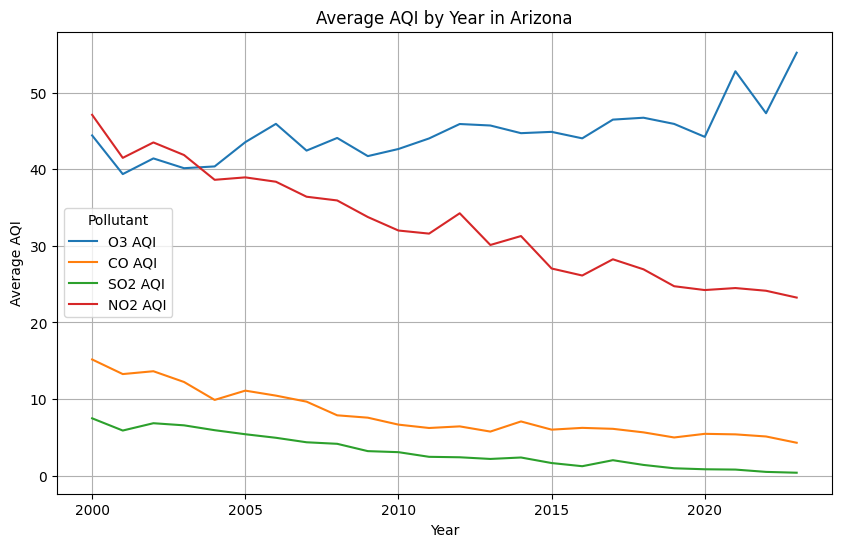

In [ ]:
aqdfAZ = aqdf[aqdf['State'] == 'Arizona']

means = aqdfAZ.groupby('year')[['O3 AQI', 'CO AQI', 'SO2 AQI', 'NO2 AQI']].mean()
means.plot(figsize=(10,6), grid=True,
           xlabel='Year', ylabel='Average AQI',
           title='Average AQI by Year in Arizona')
plt.legend(title='Pollutant')
plt.show()

This plot shows that three out of the four pollutants are decreasing in AQI score as time passes. Ozone is the only pollutant that trended upwards. Although NO2 and O3 started at near the same average AQI, only NO2 tends to decrease over time. The other two pollutants, CO and SO2, started at lower average AQI values and ended at even lower values. However, it seems that these two pollutants also saw smaller overall changes than either O3 or NO2.

These results show that CO, SO2, and NO2 are decreasing over time, which is a positive change. However, the increase in Ozone's AQI, especially being over 50, is a negative indicator of this facet of air quality.

### Mean vs AQI for Pollutants

Now that we have an idea of how the AQI for each pollutant changes, let's discover what variables are influencing this. We will take the mean column for each pollutant and compare this to the AQI for each day.

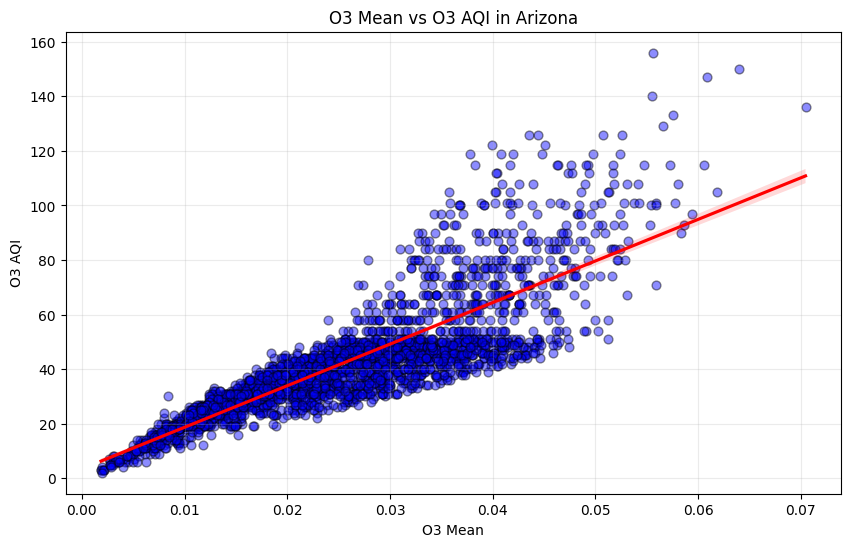

In [ ]:
plt.figure(figsize=(10, 6))
sns.regplot(
    data=aqdfAZ,
    x='O3 Mean',
    y='O3 AQI',
    scatter_kws={
        'color': 'blue',        # dot color
        'alpha': 0.45,
        's': 40,
        'edgecolor': 'k'
    },
    line_kws={
        'color': 'red',
        'zorder': 3
    },
    ci=95
)
plt.xlabel('O3 Mean')
plt.ylabel('O3 AQI')
plt.title('O3 Mean vs O3 AQI in Arizona')
plt.grid(alpha=0.25)
plt.show()

For O3's measurements, we see a clear positive relationship with the mean and AQI daily. It also seems that more variance occurs when the mean is higher, leading to more differing AQI values at these higher means. Although there are some outliers, the relationship here is clearly positive and demonstrates how the average increase in O3 density daily causes in increase in AQI.

Now, let's look at CO.

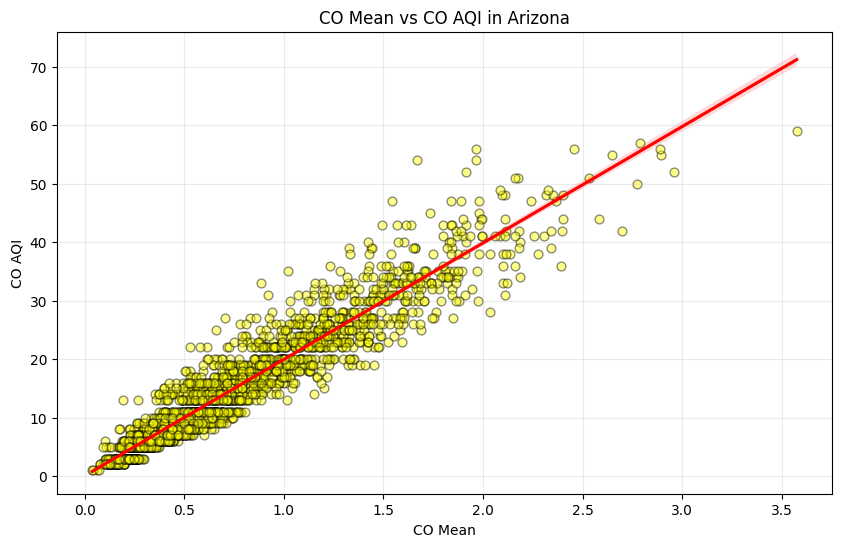

In [ ]:
plt.figure(figsize=(10, 6))
sns.regplot(
    data=aqdfAZ,
    x='CO Mean',
    y='CO AQI',
    scatter_kws={
        'color': 'yellow',        # dot color
        'alpha': 0.45,
        's': 40,
        'edgecolor': 'k'
    },
    line_kws={
        'color': 'red',
        'zorder': 3
    },
    ci=95
)
plt.xlabel('CO Mean')
plt.ylabel('CO AQI')
plt.title('CO Mean vs CO AQI in Arizona')
plt.grid(alpha=0.25)
plt.show()

asdf

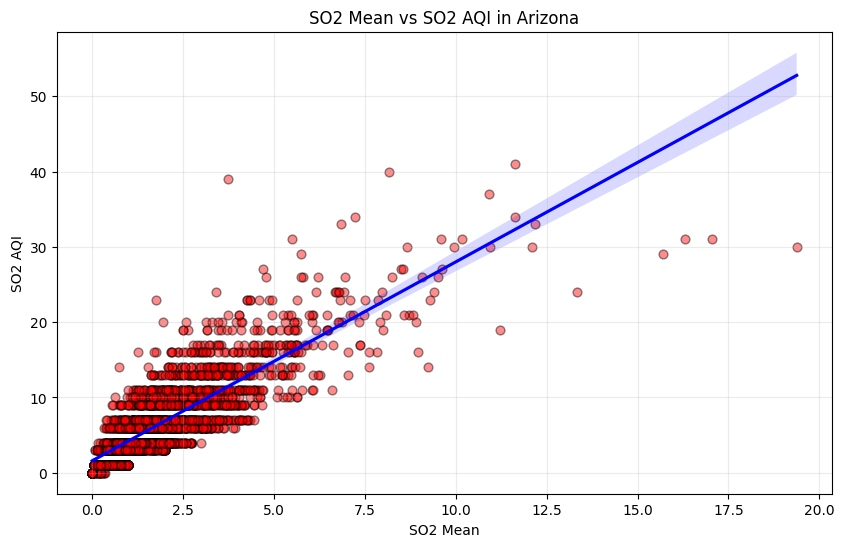

In [ ]:
plt.figure(figsize=(10, 6))
sns.regplot(
    data=aqdfAZ,
    x='SO2 Mean',
    y='SO2 AQI',
    scatter_kws={
        'color': 'red',        # dot color
        'alpha': 0.45,
        's': 40,
        'edgecolor': 'k'
    },
    line_kws={
        'color': 'blue',
        'zorder': 3
    },
    ci=95
)
plt.xlabel('SO2 Mean')
plt.ylabel('SO2 AQI')
plt.title('SO2 Mean vs SO2 AQI in Arizona')
plt.grid(alpha=0.25)
plt.show()

SO2 is a similar case to O3, showing a positive correlation between mean and AQI. We can begin to see here, however, that the mean density of SO2 averages around significantly higher values than those in O3. This is due to the difference in weights and densities between these compounds, and would be insignificant to compare. We do see again that there can be a decent amount of variance in AQI based on the mean, similar to O3.

Next is NO2.

In [ ]:
air_qualitydf = pd.read_csv('pollution_2000_2023.csv')
air_qualitydf.head()
aq_az = air_qualitydf[air_qualitydf['State'] == 'Arizona']
aq_az.head()

,Unnamed: 0,Date,Address,State,County,City,O3 Mean,O3 1st Max Value,O3 1st Max Hour,O3 AQI,...,CO 1st Max Hour,CO AQI,SO2 Mean,SO2 1st Max Value,SO2 1st Max Hour,SO2 AQI,NO2 Mean,NO2 1st Max Value,NO2 1st Max Hour,NO2 AQI
0,0,2000-01-01,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,0.019765,0.040,10.0,37.0,...,23.0,25.0,3.000000,9.0,21.0,13.0,19.041667,49.0,19.0,46.0
1,1,2000-01-02,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,0.015882,0.032,10.0,30.0,...,0.0,26.0,1.958333,3.0,22.0,4.0,22.958333,36.0,19.0,34.0
2,2,2000-01-03,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,0.009353,0.016,9.0,15.0,...,8.0,28.0,5.250000,11.0,19.0,16.0,38.125000,51.0,8.0,48.0
3,3,2000-01-04,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,0.015882,0.033,9.0,31.0,...,23.0,34.0,7.083333,16.0,8.0,23.0,40.260870,74.0,8.0,72.0
4,4,2000-01-05,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,0.007353,0.012,9.0,11.0,...,2.0,42.0,8.708333,15.0,7.0,21.0,48.450000,61.0,22.0,58.0


Text(0.5, 1.0, 'Distribution of O3 Concentration in Arizona')

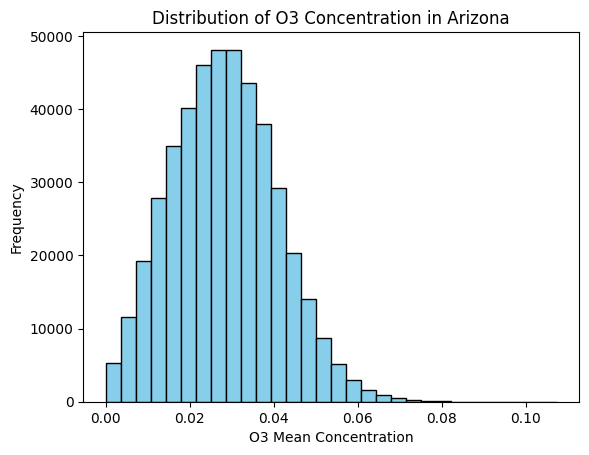

In [ ]:
plt.hist(air_qualitydf['O3 Mean'], bins = 30, color = 'skyblue', edgecolor = 'black')
plt.xlabel('O3 Mean Concentration')
plt.ylabel('Frequency')
plt.title('Distribution of O3 Concentration in Arizona')

Text(0.5, 1.0, 'Distribution of CO Concentration in Arizona')

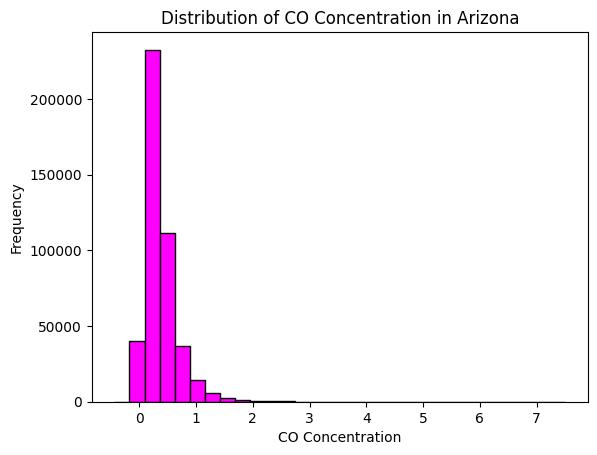

In [ ]:
plt.hist(air_qualitydf['CO Mean'], bins = 30, color = 'magenta', edgecolor = 'black')
plt.xlabel('CO Concentration')
plt.ylabel('Frequency')
plt.title('Distribution of CO Concentration in Arizona')

Text(0.5, 1.0, 'Distribution of SO2 Concentration in Arizona')

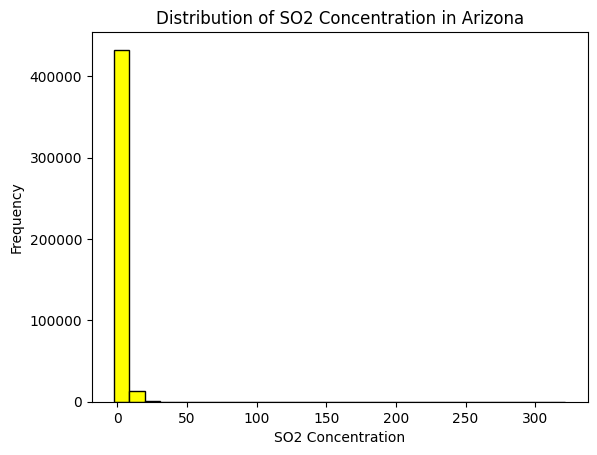

In [ ]:
plt.hist(air_qualitydf['SO2 Mean'], bins = 30, color = 'yellow', edgecolor = 'black')
plt.xlabel('SO2 Concentration')
plt.ylabel('Frequency')
plt.title('Distribution of SO2 Concentration in Arizona')

Text(0.5, 1.0, 'Distribution of NO2 Concentration in Arizona')

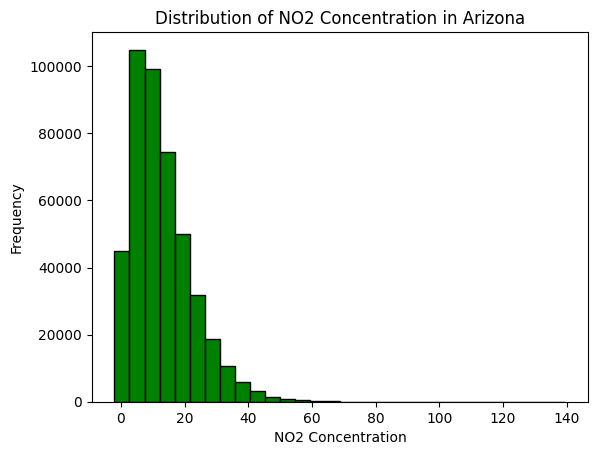

In [ ]:
plt.hist(air_qualitydf['NO2 Mean'], bins = 30, color = 'green', edgecolor = 'black')
plt.xlabel('NO2 Concentration')
plt.ylabel('Frequency')
plt.title('Distribution of NO2 Concentration in Arizona')

In [ ]:
corr_matrix = poldf[['O3 Mean', 'CO Mean', 'SO2 Mean', 'NO2 Mean']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='vlag', center=0)
plt.title('Air Pollutant Correlation Matrix')
plt.show()

NameError: name 'poldf' is not defined

# Climate Global Time Series
## Introduction
The data will be showcased through geospatial data and multiple linear regressions with multiple datasets. https://www.ncei.noaa.gov/access/monitoring/climate-at-a-glance/statewide/time-series/2/tavg/1/7/1895-2025 This website contained

In [ ]:
az_climate2018 = pd.read_csv('AZClimateData2018.csv')
az_climate2018 = az_climate2018.iloc[3:,]
az_climate2018 = az_climate2018.rename(columns={'# Title: July 2018 Arizona County Maximum Temperature':'ID',
                                                'Unnamed: 1':'County',
                                                'Unnamed: 2':'State',
                                                'Unnamed: 3':'Max Temperature',
                                                'Unnamed: 4':'Rank',
                                                'Unnamed: 5':'Anomaly',
                                                'Unnamed: 6':'Mean'})
az_climate2018 = az_climate2018[az_climate2018['County'].isin(['Maricopa County', 'Pima County'])]
az_climate2018['Max Temperature'] = pd.to_numeric(az_climate2018['Max Temperature'], errors='coerce')
az_climate2018.head()

,ID,County,State,Max Temperature,Rank,Anomaly,Mean
10,AZ-013,Maricopa County,Arizona,105.2,106,2.2,103
13,AZ-019,Pima County,Arizona,100.1,91,1.4,98.7


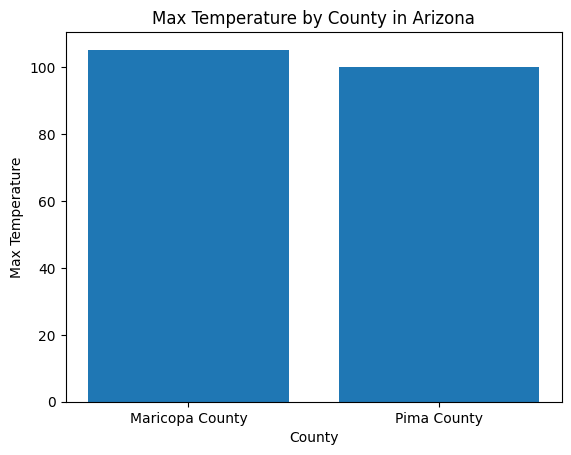

In [ ]:
plt.bar(az_climate2018['County'], az_climate2018['Max Temperature'])
plt.xlabel('County')
plt.ylabel('Max Temperature')
plt.title('Max Temperature by County in Arizona')
plt.show()

In [ ]:
az_avg_temp = pd.read_csv('AZ_AVGTemp.csv')
az_avg_temp = az_avg_temp.iloc[2:]
az_avg_temp = az_avg_temp.rename(columns={'#  Arizona July Average Temperature':'year',
    'Unnamed: 1': 'Average Temperature'})
az_avg_temp['year'] = [2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023]
az_avg_temp.head()
az_avg_temp['Average Temperature'].dtype
az_avg_temp['Average Temperature'] = pd.to_numeric(az_avg_temp['Average Temperature'], errors='coerce')

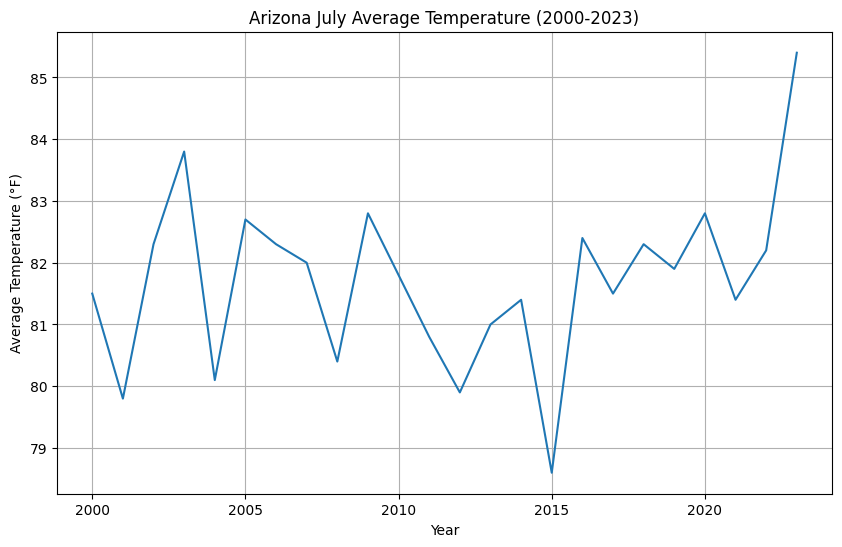

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(az_avg_temp['year'], az_avg_temp['Average Temperature'])
plt.xlabel('Year')
plt.ylabel('Average Temperature (°F)')
plt.title('Arizona July Average Temperature (2000-2023)')
plt.grid(True)
plt.show()

In [ ]:
temp_merge2018 = pd.merge(aqdfAZ, az_climate2018, on='County', how='left')
temp_merge2018 = temp_merge2018[['County', 'NO2 Mean', 'year', 'month']]
temp_merge2018 = temp_merge2018[temp_merge2018['year']==2018]
temp_merge2018 = temp_merge2018[temp_merge2018['month']==7]
temp_merge2018.head()

,County,NO2 Mean,year,month


In [ ]:
avg_merge = pd.merge(aqdf, az_avg_temp, on='year', how='left')
avg_merge.head()

,Unnamed: 0,Date,Address,State,County,City,O3 Mean,O3 1st Max Value,O3 1st Max Hour,O3 AQI,...,SO2 AQI,NO2 Mean,NO2 1st Max Value,NO2 1st Max Hour,NO2 AQI,date_dt,day,month,year,Average Temperature
0,0,2000-01-01,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,0.019765,0.040,10,37,...,13.0,19.041667,49.0,19.0,46.0,2000-01-01,1,1,2000,81.5
1,1,2000-01-02,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,0.015882,0.032,10,30,...,4.0,22.958333,36.0,19.0,34.0,2000-01-02,2,1,2000,81.5
2,2,2000-01-03,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,0.009353,0.016,9,15,...,16.0,38.125000,51.0,8.0,48.0,2000-01-03,3,1,2000,81.5
3,3,2000-01-04,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,0.015882,0.033,9,31,...,23.0,40.260870,74.0,8.0,72.0,2000-01-04,4,1,2000,81.5
4,4,2000-01-05,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,0.007353,0.012,9,11,...,21.0,48.450000,61.0,22.0,58.0,2000-01-05,5,1,2000,81.5


In [ ]:
counties = gpd.read_file('https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_county_500k.zip')
az_counties = counties[counties['STATEFP'] == '04']
az_counties =az_counties.rename(columns={'NAME':'County'})
az_counties.head()


,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,County,LSAD,ALAND,AWATER,geometry
484,04,005,00025443,0500000US04005,04005,Coconino,06,48222143094,110123852,"POLYGON ((-113.35413 36.04209, -113.35204 36.0..."
485,04,009,00025444,0500000US04009,04009,Graham,06,11972737302,47477716,"POLYGON ((-110.45812 33.29298, -110.45719 33.2..."
486,04,013,00037026,0500000US04013,04013,Maricopa,06,23825949527,64236947,"POLYGON ((-113.33438 33.48526, -113.33346 33.5..."
733,04,007,00040471,0500000US04007,04007,Gila,06,12323152727,97113523,"POLYGON ((-111.72065 34.1627, -111.71978 34.16..."
846,04,001,00025441,0500000US04001,04001,Apache,06,29001320728,54152352,"POLYGON ((-110.00068 36.99797, -109.93414 36.9..."


<Axes: >

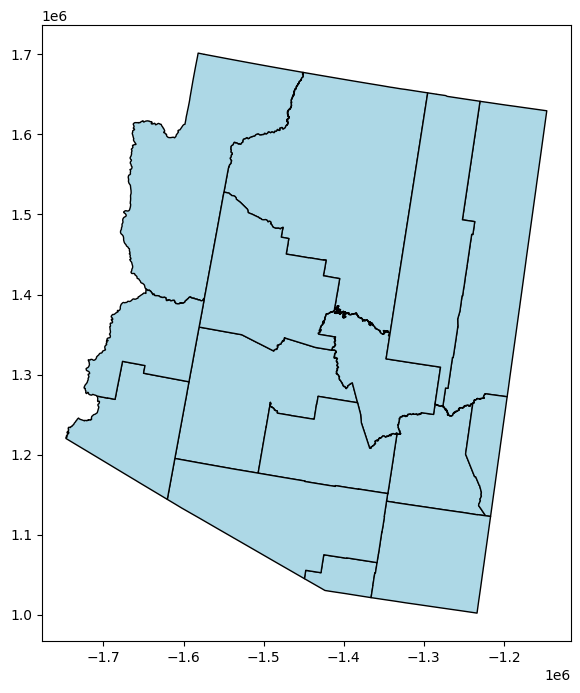

In [ ]:
az_counties = az_counties.to_crs(epsg=5070)

az_counties.plot(edgecolor='black', facecolor='lightblue', figsize=(8,8))

In [ ]:
aq_summary = avg_merge.groupby('County').agg({
    'O3 Mean': 'mean',
    'CO Mean': 'mean',
    'SO2 Mean': 'mean',
    'NO2 Mean': 'mean'})
aq_summary.head()

,O3 Mean,CO Mean,SO2 Mean,NO2 Mean
County,,,,
Adams,0.022318,0.563135,1.831328,20.444462
Alameda,0.019243,0.696967,1.814211,19.085348
Alexandria City,0.030431,0.400757,4.257894,21.793722
Allegheny,0.029854,0.327216,7.721422,19.401557
Aroostook,0.027343,0.175892,0.806358,2.595029


In [ ]:
aq_map_merge = pd.merge(az_counties, aq_summary, on='County', how='left')
aq_map_merge.head()

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,County,LSAD,ALAND,AWATER,geometry,O3 Mean,CO Mean,SO2 Mean,NO2 Mean
0,04,005,00025443,0500000US04005,04005,Coconino,06,48222143094,110123852,"POLYGON ((-1540947.192 1584540.288, -1540653.1...",NaN,NaN,NaN,NaN
1,04,009,00025444,0500000US04009,04009,Graham,06,11972737302,47477716,"POLYGON ((-1332581.497 1237562.153, -1332458.3...",NaN,NaN,NaN,NaN
2,04,013,00037026,0500000US04013,04013,Maricopa,06,23825949527,64236947,"POLYGON ((-1591088.233 1302983.471, -1589653.7...",0.024584,0.717743,2.126987,24.993213
3,04,007,00040471,0500000US04007,04007,Gila,06,12323152727,97113523,"POLYGON ((-1431927.361 1351869, -1431823.324 1...",NaN,NaN,NaN,NaN
4,04,001,00025441,0500000US04001,04001,Apache,06,29001320728,54152352,"POLYGON ((-1229880.912 1641288.227, -1224073.7...",NaN,NaN,NaN,NaN


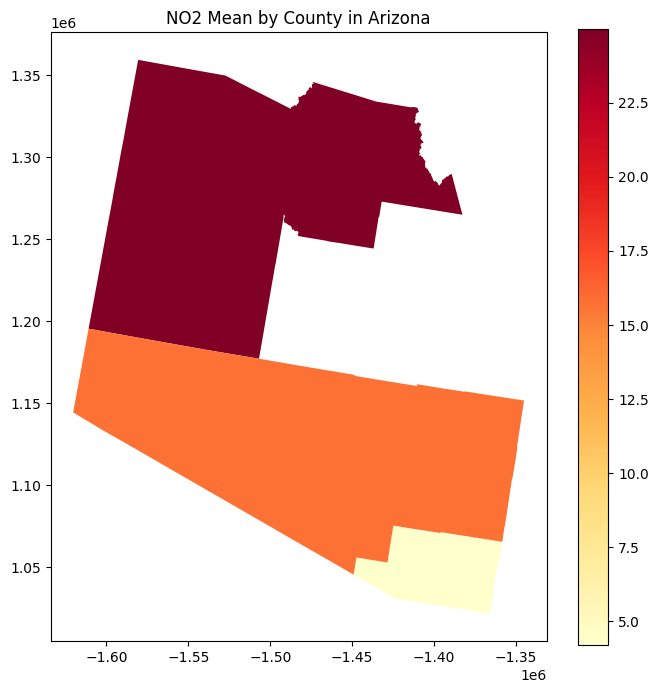

In [ ]:
aq_map_merge.plot(column = 'NO2 Mean',cmap = 'YlOrRd', legend = True, figsize = (8,8))
plt.title("NO2 Mean by County in Arizona")
plt.show()

In [ ]:
merge_df = pd.merge(aq_map_merge, avg_merge, on='County', how='left')
merge_df = merge_df.dropna()
merge_df = merge_df.drop_duplicates()
merge_df = merge_df[['year', 'Average Temperature', 'NO2 AQI']]
merge_df['year'] = pd.to_numeric(merge_df['year'], errors='coerce')
merge_df.head()





,year,Average Temperature,NO2 AQI
2,2000.0,81.5,46.0
3,2000.0,81.5,34.0
4,2000.0,81.5,48.0
5,2000.0,81.5,72.0
6,2000.0,81.5,58.0


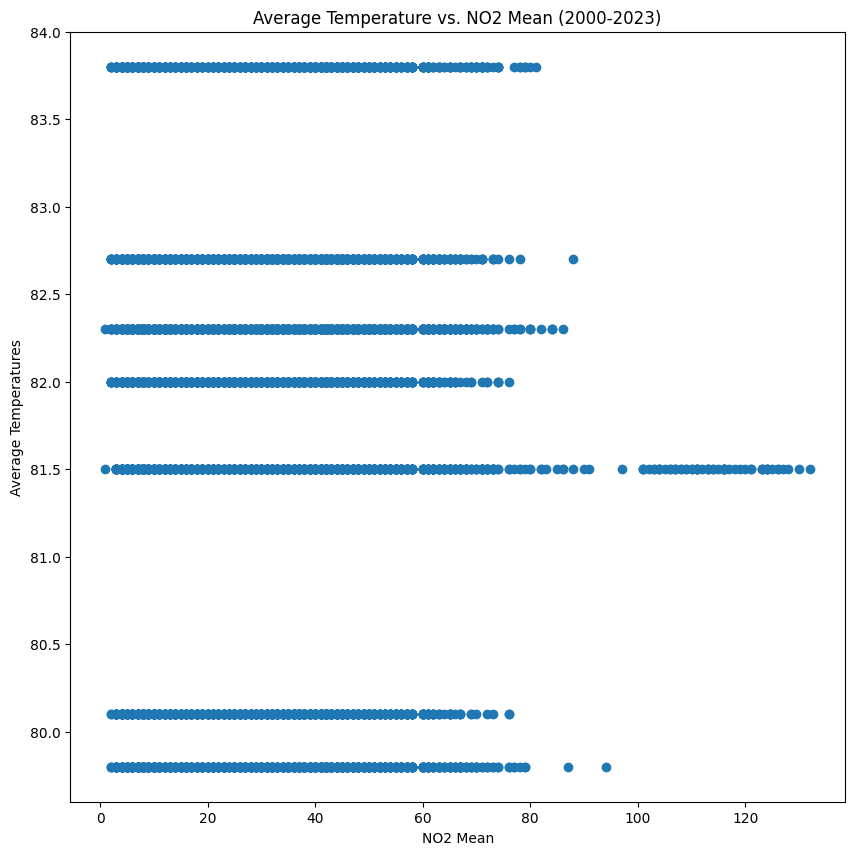

In [ ]:
plt.figure(figsize=(10, 10))
plt.scatter(merge_df['NO2 AQI'], merge_df['Average Temperature'])
plt.xlabel('NO2 Mean')
plt.ylabel('Average Temperatures')
plt.title('Average Temperature vs. NO2 Mean (2000-2023)')
plt.show()

In [ ]:
temp_corr = merge_df['Average Temperature'].corr(merge_df['NO2 AQI'])
print("Correlation between Average Temperature and NO2 mean:", temp_corr)

Correlation between Average Temperature and NO2 mean: 0.051882016654629465


# USDA Economic Research Service - Unemployment and Household Income
## Introduction



In [ ]:
undf = pd.read_csv('Unemployment2023.csv')

unemployment_df = undf[
    undf['Attribute'].str.contains('Unemployment_rate') &
    (undf['FIPS_Code'] > 1000)
].copy()

unemployment_df['Year'] = unemployment_df['Attribute'].str.split('_').str[-1].astype(int)
unemployment_df['County'] = unemployment_df['Area_Name'].apply(lambda x: x.split(',')[0].replace(' County', ''))
unemployment_df.rename(columns={'Value': 'Unemployment Rate', 'State': 'State_Abbr'}, inplace=True)
unemployment_df = unemployment_df[['Year', 'State_Abbr', 'County', 'Unemployment Rate']]

poldf = pd.read_csv('pollution_2000_2023.csv')
poldf['Date'] = pd.to_datetime(poldf['Date'])
poldf['Year'] = poldf['Date'].dt.year

state_mapping = {
    'Alabama': 'AL', 'Alaska': 'AK', 'Arizona': 'AZ', 'Arkansas': 'AR', 'California': 'CA',
    'Colorado': 'CO', 'Connecticut': 'CT', 'Delaware': 'DE', 'Florida': 'FL', 'Georgia': 'GA',
    'Hawaii': 'HI', 'Idaho': 'ID', 'Illinois': 'IL', 'Indiana': 'IN', 'Iowa': 'IA',
    'Kansas': 'KS', 'Kentucky': 'KY', 'Louisiana': 'LA', 'Maine': 'ME', 'Maryland': 'MD',
    'Massachusetts': 'MA', 'Michigan': 'MI', 'Minnesota': 'MN', 'Mississippi': 'MS',
    'Missouri': 'MO', 'Montana': 'MT', 'Nebraska': 'NE', 'Nevada': 'NV', 'New Hampshire': 'NH',
    'New Jersey': 'NJ', 'New Mexico': 'NM', 'New York': 'NY', 'North Carolina': 'NC',
    'North Dakota': 'ND', 'Ohio': 'OH', 'Oklahoma': 'OK', 'Oregon': 'OR', 'Pennsylvania': 'PA',
    'Rhode Island': 'RI', 'South Carolina': 'SC', 'South Dakota': 'SD', 'Tennessee': 'TN',
    'Texas': 'TX', 'Utah': 'UT', 'Vermont': 'VT', 'Virginia': 'VA', 'Washington': 'WA',
    'West Virginia': 'WV', 'Wisconsin': 'WI', 'Wyoming': 'WY', 'District Of Columbia': 'DC',
    'Puerto Rico': 'PR'
}
poldf['State_Abbr'] = poldf['State'].map(state_mapping)
pollution_df = poldf.groupby(['Year', 'State_Abbr', 'County'])['NO2 Mean'].mean().reset_index()
merged_df = pd.merge(unemployment_df, pollution_df, on=['Year', 'State_Abbr', 'County'])
merged_df.dropna(inplace=True)

The unemployed dataset contains several metrics to categorize unemployment. That includes total population that is unemployed, percentage, and 20 others. So I created a copy of the undf import that selects for the proper category (attribute). Then the datset has its columns renamed to be more accurate to the selected attribute aand then we also remove the work county from each counties name to match the other dataset. A second import of the pollution csv is created to modify to match the unemployment one, and the states are changed from abbreviations to their full names.

In [ ]:
overall_correlation = merged_df['Unemployment Rate'].corr(merged_df['NO2 Mean'])
print(f"Overall Correlation (2000-2023): {overall_correlation:.4f}")

plt.figure(figsize=(12, 7))
sns.regplot(data=merged_df, x='NO2 Mean', y='Unemployment Rate', line_kws={"color": "red"}, scatter_kws={'alpha': 0.1})
plt.title('Unemployment Rate vs. NO2 Mean by County (2000-2023)')
plt.xlabel('Average Annual NO2 Mean')
plt.ylabel('Unemployment Rate (%)')
plt.grid(True)
plt.show()

NameError: name 'merged_df' is not defined

This graph shows the relationship for all recorded counties by their average annual NO2 pollution and their unemployment rate. The results is a correlation of 0.1698. So it is not a very high relationship but it certainly shows evidence that pollution is related to unemployment. Which would indicate other poor economic metrics.

In [ ]:
correlation_by_year = merged_df.groupby('Year')[['Unemployment Rate', 'NO2 Mean']].corr().unstack().iloc[:, 1]

plt.figure(figsize=(12, 6))
correlation_by_year.plot(marker='o')
plt.title('Correlation between Unemployment and NO2 Mean Over Time')
plt.xlabel('Year')
plt.ylabel('Correlation')
plt.grid(True)
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
plt.show()

This graph shows the yearly coorelation between pollution and unemployment and this makes it more clear that the relationship is likely true. It also, shows that before the 2008 and 2020 recessions there is a drop in correlation. Those economic events could be the explaination for those.

In [ ]:
poldf_az = poldf[poldf['State_Abbr'] == 'AZ'].copy()
pollution_df = poldf_az.groupby(['Year', 'State_Abbr', 'County'])['NO2 Mean'].mean().reset_index()

merged_df = pd.merge(unemployment_df, pollution_df, on=['Year', 'State_Abbr', 'County'])
merged_df.dropna(inplace=True)

overall_correlation = merged_df['Unemployment Rate'].corr(merged_df['NO2 Mean'])
print(f"Overall Correlation for Arizona (2000-2023): {overall_correlation:.4f}")

plt.figure(figsize=(12, 7))
sns.regplot(data=merged_df, x='NO2 Mean', y='Unemployment Rate', line_kws={"color": "red"}, scatter_kws={'alpha': 0.3})
plt.title('Unemployment Rate vs. NO2 Mean in Arizona Counties (2000-2023)')
plt.xlabel('Average Annual NO2 Mean')
plt.ylabel('Unemployment Rate (%)')
plt.grid(True)
plt.show()

This graph only looks at Arizona counties between 2000 and 2023. The result is a negative correlation of -0.1. Though Arizona is likely an outlier when it comes to the national relationship. This is because Arizona's population is focused in two metro areas (Pheonix and Tuscon) and both are represented by one county. Those two counties will then have higher pollution averages as that is where most people live and their unemployment is likely to be lower than more rural counties.

In [ ]:
state_unemployment_df = unemployment_df.groupby(['Year', 'State_Abbr'])['Unemployment Rate'].mean().reset_index()

state_pollution_df = poldf.groupby(['Year', 'State_Abbr'])['NO2 Mean'].mean().reset_index()

merged_df = pd.merge(state_unemployment_df, state_pollution_df, on=['Year', 'State_Abbr'])
merged_df.dropna(inplace=True)

overall_correlation = merged_df['Unemployment Rate'].corr(merged_df['NO2 Mean'])
print(f"Overall State-Level Correlation (2000-2023): {overall_correlation:.4f}")

plt.figure(figsize=(12, 7))
sns.regplot(data=merged_df, x='NO2 Mean', y='Unemployment Rate', line_kws={"color": "red"}, scatter_kws={'alpha': 0.3})
plt.title('State-Level Unemployment Rate vs. NO2 Mean (2000-2023)')
plt.xlabel('Average Annual NO2 Mean (State)')
plt.ylabel('Average Annual Unemployment Rate (State %)')
plt.grid(True)
plt.savefig('state_unemployment_vs_pollution.png')
plt.show()

correlation_by_year = merged_df.groupby('Year')[['Unemployment Rate', 'NO2 Mean']].corr().unstack().iloc[:, 1]


plt.figure(figsize=(12, 6))
correlation_by_year.plot(marker='o')
plt.title('State-Level Correlation between Unemployment and NO2 Mean Over Time')
plt.xlabel('Year')
plt.ylabel('Pearson Correlation')
plt.grid(True)
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
plt.savefig('state_correlation_over_time.png')
plt.show()

NameError: name 'unemployment_df' is not defined

# Results, Implications, Challenges

## Research Question



In [ ]:
from scipy import stats

# Filter data for early and late years
o3_early_years = aqdf[aqdf['year'].isin([2000, 2001, 2002])]['O3 Mean']
o3_late_years = aqdf[aqdf['year'].isin([2021, 2022, 2023])]['O3 Mean']

# Perform independent samples t-test
ttest_result = stats.ttest_ind(o3_early_years, o3_late_years, nan_policy='omit')

print(f"T-test results for O3 Mean (2000-2002 vs 2021-2023):")
print(f"  T-statistic: {ttest_result.statistic:.4f}")
print(f"  P-value: {ttest_result.pvalue:.4f}")

# Interpret the results
alpha = 0.05
if ttest_result.pvalue < alpha:
    print("  The difference in O3 Mean between the early and late years is statistically significant.")
else:
    print("  The difference in O3 Mean between the early and late years is not statistically significant.")

T-test results for O3 Mean (2000-2002 vs 2021-2023):
  T-statistic: -40.4842
  P-value: 0.0000
  The difference in O3 Mean between the early and late years is statistically significant.


In [ ]:
# Filter data for early and late years
co_early_years = aqdf[aqdf['year'].isin([2000, 2001, 2002])]['CO Mean']
co_late_years = aqdf[aqdf['year'].isin([2021, 2022, 2023])]['CO Mean']

# Perform independent samples t-test
ttest_result = stats.ttest_ind(co_early_years, co_late_years, nan_policy='omit')

print(f"T-test results for CO Mean (2000-2002 vs 2021-2023):")
print(f"  T-statistic: {ttest_result.statistic:.4f}")
print(f"  P-value: {ttest_result.pvalue:.4f}")

# Interpret the results
alpha = 0.05
if ttest_result.pvalue < alpha:
    print("  The difference in CO Mean between the early and late years is statistically significant.")
else:
    print("  The difference in CO Mean between the early and late years is not statistically significant.")

T-test results for CO Mean (2000-2002 vs 2021-2023):
  T-statistic: 161.1326
  P-value: 0.0000
  The difference in CO Mean between the early and late years is statistically significant.


In [ ]:
# Filter data for early and late years
so2_early_years = aqdf[aqdf['year'].isin([2000, 2001, 2002])]['SO2 Mean']
so2_late_years = aqdf[aqdf['year'].isin([2021, 2022, 2023])]['SO2 Mean']

# Perform independent samples t-test
ttest_result = stats.ttest_ind(so2_early_years, so2_late_years, nan_policy='omit')

print(f"T-test results for SO2 Mean (2000-2002 vs 2021-2023):")
print(f"  T-statistic: {ttest_result.statistic:.4f}")
print(f"  P-value: {ttest_result.pvalue:.4f}")

# Interpret the results
alpha = 0.05
if ttest_result.pvalue < alpha:
    print("  The difference in SO2 Mean between the early and late years is statistically significant.")
else:
    print("  The difference in SO2 Mean between the early and late years is not statistically significant.")

T-test results for SO2 Mean (2000-2002 vs 2021-2023):
  T-statistic: 203.2851
  P-value: 0.0000
  The difference in SO2 Mean between the early and late years is statistically significant.


In [ ]:
# Filter data for early and late years
no2_early_years = aqdf[aqdf['year'].isin([2000, 2001, 2002])]['NO2 Mean']
no2_late_years = aqdf[aqdf['year'].isin([2021, 2022, 2023])]['NO2 Mean']

# Perform independent samples t-test
ttest_result = stats.ttest_ind(no2_early_years, no2_late_years, nan_policy='omit')

print(f"T-test results for NO2 Mean (2000-2002 vs 2021-2023):")
print(f"  T-statistic: {ttest_result.statistic:.4f}")
print(f"  P-value: {ttest_result.pvalue:.4f}")

# Interpret the results
alpha = 0.05
if ttest_result.pvalue < alpha:
    print("  The difference in NO2 Mean between the early and late years is statistically significant.")
else:
    print("  The difference in NO2 Mean between the early and late years is not statistically significant.")

T-test results for NO2 Mean (2000-2002 vs 2021-2023):
  T-statistic: 172.5066
  P-value: 0.0000
  The difference in NO2 Mean between the early and late years is statistically significant.


In [ ]:
# Filter data for early and late years
o3_early_years = aqdfAZ[aqdfAZ['year'].isin([2000, 2001, 2002])]['O3 Mean']
o3_late_years = aqdfAZ[aqdfAZ['year'].isin([2021, 2022, 2023])]['O3 Mean']

# Perform independent samples t-test
ttest_result = stats.ttest_ind(o3_early_years, o3_late_years, nan_policy='omit')

print(f"T-test results for O3 Mean (2000-2002 vs 2021-2023):")
print(f"  T-statistic: {ttest_result.statistic:.4f}")
print(f"  P-value: {ttest_result.pvalue:.4f}")

# Interpret the results
alpha = 0.05
if ttest_result.pvalue < alpha:
    print("  The difference in O3 Mean between the early and late years is statistically significant.")
else:
    print("  The difference in O3 Mean between the early and late years is not statistically significant.")

T-test results for O3 Mean (2000-2002 vs 2021-2023):
  T-statistic: -29.5289
  P-value: 0.0000
  The difference in O3 Mean between the early and late years is statistically significant.


In [ ]:
# Filter data for early and late years
co_early_years = aqdfAZ[aqdfAZ['year'].isin([2000, 2001, 2002])]['CO Mean']
co_late_years = aqdfAZ[aqdfAZ['year'].isin([2021, 2022, 2023])]['CO Mean']

# Perform independent samples t-test
ttest_result = stats.ttest_ind(co_early_years, co_late_years, nan_policy='omit')

print(f"T-test results for CO Mean (2000-2002 vs 2021-2023):")
print(f"  T-statistic: {ttest_result.statistic:.4f}")
print(f"  P-value: {ttest_result.pvalue:.4f}")

# Interpret the results
alpha = 0.05
if ttest_result.pvalue < alpha:
    print("  The difference in CO Mean between the early and late years is statistically significant.")
else:
    print("  The difference in CO Mean between the early and late years is not statistically significant.")

T-test results for CO Mean (2000-2002 vs 2021-2023):
  T-statistic: 41.7636
  P-value: 0.0000
  The difference in CO Mean between the early and late years is statistically significant.


In [ ]:
# Filter data for early and late years
so2_early_years = aqdfAZ[aqdfAZ['year'].isin([2000, 2001, 2002])]['SO2 Mean']
so2_late_years = aqdfAZ[aqdfAZ['year'].isin([2021, 2022, 2023])]['SO2 Mean']

# Perform independent samples t-test
ttest_result = stats.ttest_ind(so2_early_years, so2_late_years, nan_policy='omit')

print(f"T-test results for SO2 Mean (2000-2002 vs 2021-2023):")
print(f"  T-statistic: {ttest_result.statistic:.4f}")
print(f"  P-value: {ttest_result.pvalue:.4f}")

# Interpret the results
alpha = 0.05
if ttest_result.pvalue < alpha:
    print("  The difference in SO2 Mean between the early and late years is statistically significant.")
else:
    print("  The difference in SO2 Mean between the early and late years is not statistically significant.")

T-test results for SO2 Mean (2000-2002 vs 2021-2023):
  T-statistic: 49.7248
  P-value: 0.0000
  The difference in SO2 Mean between the early and late years is statistically significant.


In [ ]:
# Filter data for early and late years
no2_early_years = aqdfAZ[aqdfAZ['year'].isin([2000, 2001, 2002])]['NO2 Mean']
no2_late_years = aqdfAZ[aqdfAZ['year'].isin([2021, 2022, 2023])]['NO2 Mean']

# Perform independent samples t-test
ttest_result = stats.ttest_ind(no2_early_years, no2_late_years, nan_policy='omit')

print(f"T-test results for NO2 Mean (2000-2002 vs 2021-2023):")
print(f"  T-statistic: {ttest_result.statistic:.4f}")
print(f"  P-value: {ttest_result.pvalue:.4f}")

# Interpret the results
alpha = 0.05
if ttest_result.pvalue < alpha:
    print("  The difference in NO2 Mean between the early and late years is statistically significant.")
else:
    print("  The difference in NO2 Mean between the early and late years is not statistically significant.")

T-test results for NO2 Mean (2000-2002 vs 2021-2023):
  T-statistic: 45.5627
  P-value: 0.0000
  The difference in NO2 Mean between the early and late years is statistically significant.


In [ ]:
# Filter data for Arizona
aqdf_az = aqdf[aqdf['State'] == 'Arizona']

# Calculate the mean O3 Mean for Arizona (2000-2023)
o3_mean_az = aqdf_az['O3 Mean'].mean()

# Calculate the overall mean O3 Mean for the entire dataset (2000-2023)
o3_mean_overall = aqdf['O3 Mean'].mean()

print(f"Average O3 Mean in Arizona (2000-2023): {o3_mean_az:.4f}")
print(f"Overall Average O3 Mean (2000-2023): {o3_mean_overall:.4f}")

Average O3 Mean in Arizona (2000-2023): 0.0291
Overall Average O3 Mean (2000-2023): 0.0286


In [ ]:
from scipy import stats

# Get the O3 Mean data for Arizona and the entire dataset
o3_az = aqdf[aqdf['State'] == 'Arizona']['O3 Mean']
o3_overall = aqdf['O3 Mean']

# Perform independent samples t-test
# We assume unequal variances since the sample sizes and potential distributions might differ.
ttest_result_az_overall = stats.ttest_ind(o3_az, o3_overall, equal_var=False, nan_policy='omit')

print(f"T-test results for O3 Mean (Arizona vs Overall):")
print(f"  T-statistic: {ttest_result_az_overall.statistic:.4f}")
print(f"  P-value: {ttest_result_az_overall.pvalue:.4f}")

# Interpret the results
alpha = 0.05
if ttest_result_az_overall.pvalue < alpha:
    print("  The difference in O3 Mean between Arizona and the overall dataset is statistically significant.")
else:
    print("  The difference in O3 Mean between Arizona and the overall dataset is not statistically significant.")

T-test results for O3 Mean (Arizona vs Overall):
  T-statistic: 6.5828
  P-value: 0.0000
  The difference in O3 Mean between Arizona and the overall dataset is statistically significant.


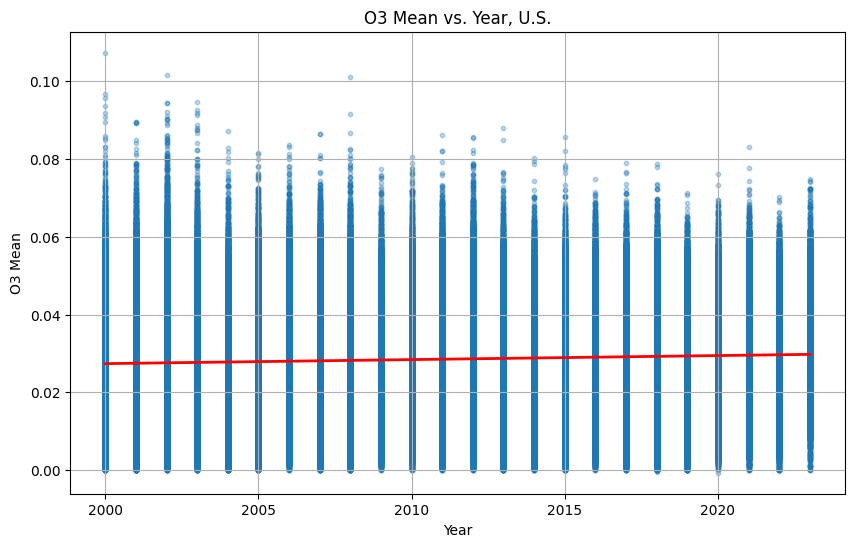

Slope of the regression line: 0.000104
P-value: 0.0000
R-squared: 0.0032


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# Create a regression plot
plt.figure(figsize=(10, 6))
sns.regplot(data=aqdf, x='year', y='O3 Mean',
            scatter_kws={'alpha': 0.3, 's': 10}, # Adjust alpha and size for points
            line_kws={'color': 'red', 'linewidth': 2}) # Set line color and width
plt.title('O3 Mean vs. Year, U.S.')
plt.xlabel('Year')
plt.ylabel('O3 Mean')
plt.grid(True)
plt.show()

# Calculate the slope of the regression line
slope, intercept, r_value, p_value, std_err = stats.linregress(aqdf['year'], aqdf['O3 Mean'])

print(f"Slope of the regression line: {slope:.6f}")
print(f"P-value: {p_value:.4f}")
print(f"R-squared: {r_value**2:.4f}")

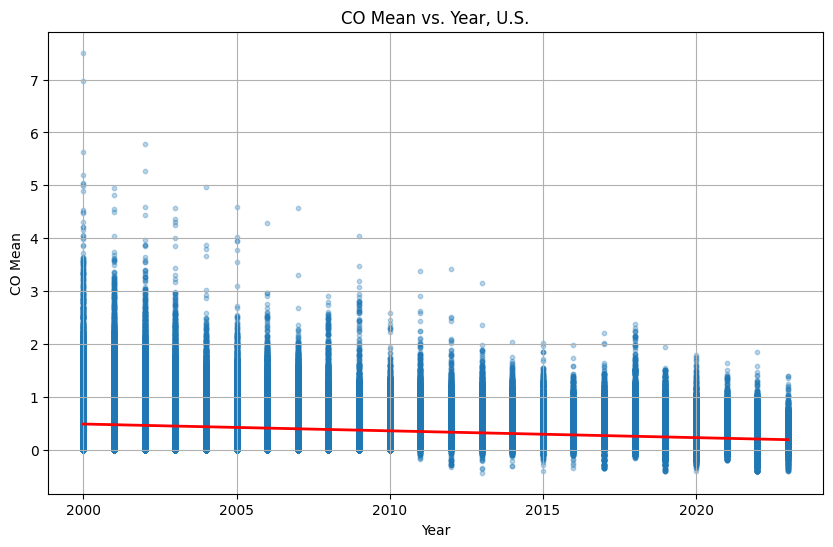

Slope of the regression line: -0.012881
P-value: 0.0000
R-squared: 0.0956


In [ ]:
# Create a regression plot
plt.figure(figsize=(10, 6))
sns.regplot(data=aqdf, x='year', y='CO Mean',
            scatter_kws={'alpha': 0.3, 's': 10}, # Adjust alpha and size for points
            line_kws={'color': 'red', 'linewidth': 2}) # Set line color and width
plt.title('CO Mean vs. Year, U.S.')
plt.xlabel('Year')
plt.ylabel('CO Mean')
plt.grid(True)
plt.show()

# Calculate the slope of the regression line
slope, intercept, r_value, p_value, std_err = stats.linregress(aqdf['year'], aqdf['CO Mean'])

print(f"Slope of the regression line: {slope:.6f}")
print(f"P-value: {p_value:.4f}")
print(f"R-squared: {r_value**2:.4f}")

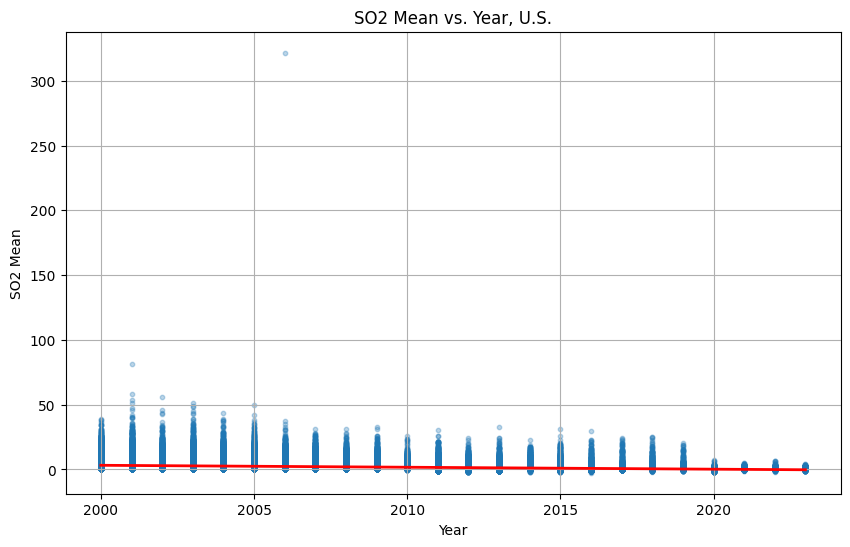

Slope of the regression line: -0.150213
P-value: 0.0000
R-squared: 0.1702


In [ ]:
# Create a regression plot
plt.figure(figsize=(10, 6))
sns.regplot(data=aqdf, x='year', y='SO2 Mean',
            scatter_kws={'alpha': 0.3, 's': 10}, # Adjust alpha and size for points
            line_kws={'color': 'red', 'linewidth': 2}) # Set line color and width
plt.title('SO2 Mean vs. Year, U.S.')
plt.xlabel('Year')
plt.ylabel('SO2 Mean')
plt.grid(True)
plt.show()

# Calculate the slope of the regression line
slope, intercept, r_value, p_value, std_err = stats.linregress(aqdf['year'], aqdf['SO2 Mean'])

print(f"Slope of the regression line: {slope:.6f}")
print(f"P-value: {p_value:.4f}")
print(f"R-squared: {r_value**2:.4f}")

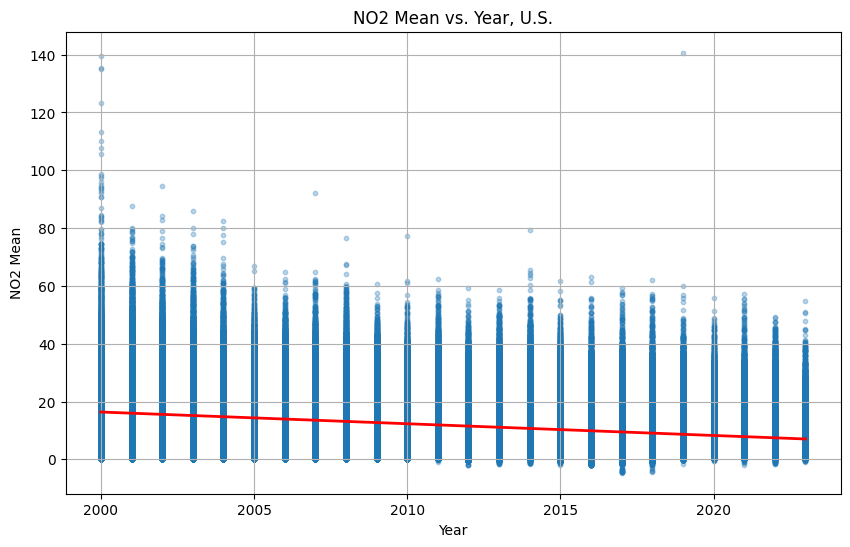

Slope of the regression line: -0.405522
P-value: 0.0000
R-squared: 0.0898


In [ ]:
# Create a regression plot
plt.figure(figsize=(10, 6))
sns.regplot(data=aqdf, x='year', y='NO2 Mean',
            scatter_kws={'alpha': 0.3, 's': 10}, # Adjust alpha and size for points
            line_kws={'color': 'red', 'linewidth': 2}) # Set line color and width
plt.title('NO2 Mean vs. Year, U.S.')
plt.xlabel('Year')
plt.ylabel('NO2 Mean')
plt.grid(True)
plt.show()

# Calculate the slope of the regression line
slope, intercept, r_value, p_value, std_err = stats.linregress(aqdf['year'], aqdf['NO2 Mean'])

print(f"Slope of the regression line: {slope:.6f}")
print(f"P-value: {p_value:.4f}")
print(f"R-squared: {r_value**2:.4f}")

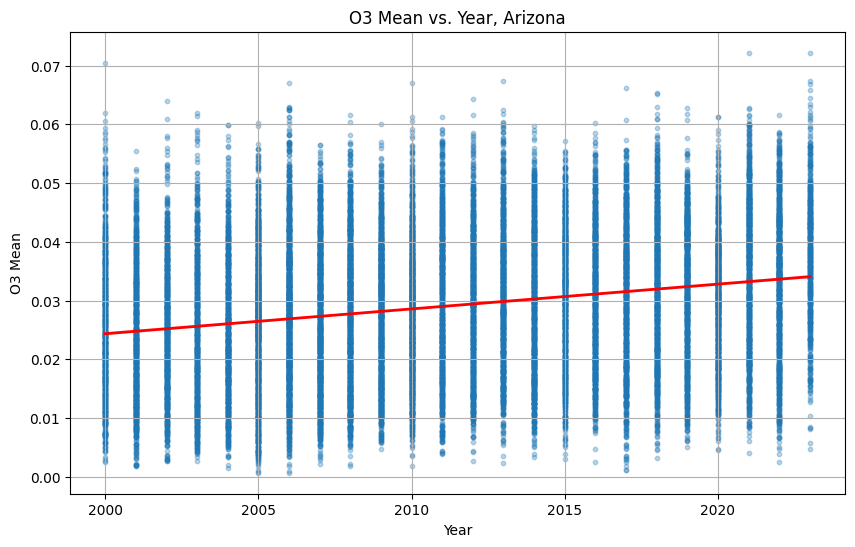

Slope of the regression line: 0.000422
P-value: 0.0000
R-squared: 0.0528


In [ ]:
# Create a regression plot
plt.figure(figsize=(10, 6))
sns.regplot(data=aqdfAZ, x='year', y='O3 Mean',
            scatter_kws={'alpha': 0.3, 's': 10}, # Adjust alpha and size for points
            line_kws={'color': 'red', 'linewidth': 2}) # Set line color and width
plt.title('O3 Mean vs. Year, Arizona')
plt.xlabel('Year')
plt.ylabel('O3 Mean')
plt.grid(True)
plt.show()

# Calculate the slope of the regression line
slope, intercept, r_value, p_value, std_err = stats.linregress(aqdfAZ['year'], aqdfAZ['O3 Mean'])

print(f"Slope of the regression line: {slope:.6f}")
print(f"P-value: {p_value:.4f}")
print(f"R-squared: {r_value**2:.4f}")

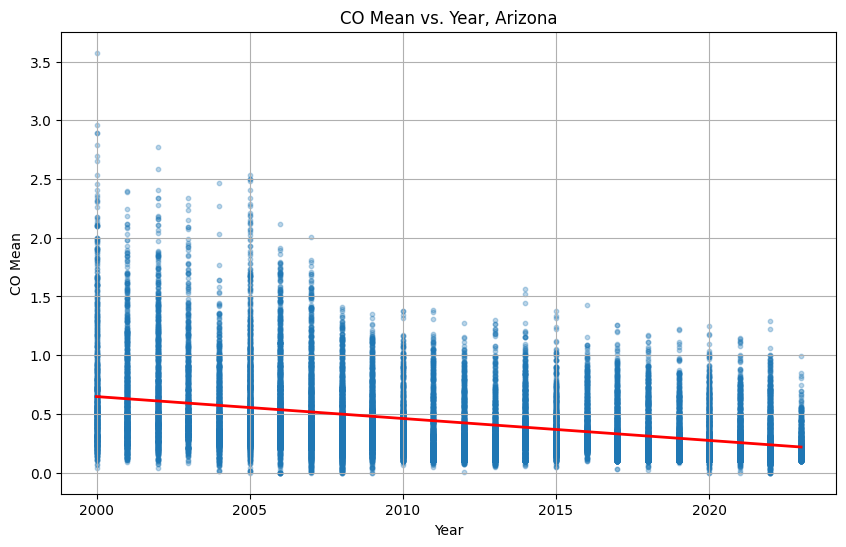

Slope of the regression line: -0.018670
P-value: 0.0000
R-squared: 0.1489


In [ ]:
# Create a regression plot
plt.figure(figsize=(10, 6))
sns.regplot(data=aqdfAZ, x='year', y='CO Mean',
            scatter_kws={'alpha': 0.3, 's': 10}, # Adjust alpha and size for points
            line_kws={'color': 'red', 'linewidth': 2}) # Set line color and width
plt.title('CO Mean vs. Year, Arizona')
plt.xlabel('Year')
plt.ylabel('CO Mean')
plt.grid(True)
plt.show()

# Calculate the slope of the regression line
slope, intercept, r_value, p_value, std_err = stats.linregress(aqdfAZ['year'], aqdfAZ['CO Mean'])

print(f"Slope of the regression line: {slope:.6f}")
print(f"P-value: {p_value:.4f}")
print(f"R-squared: {r_value**2:.4f}")

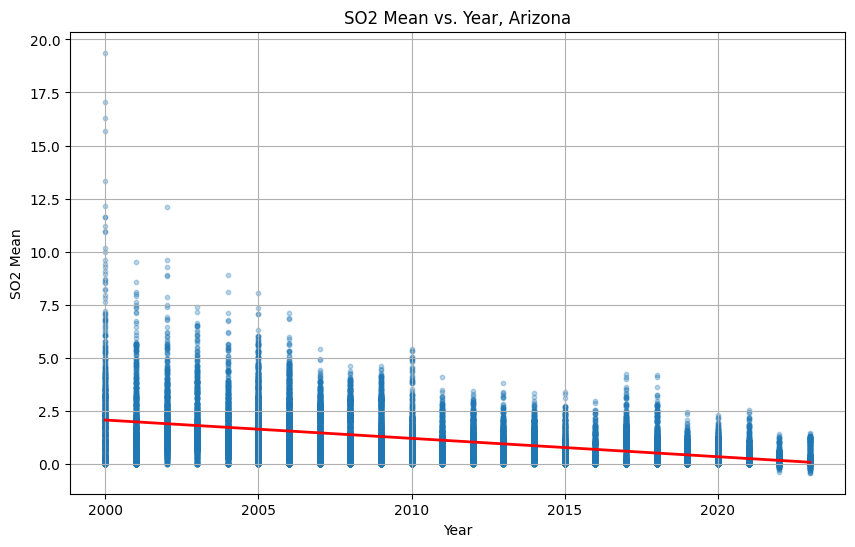

Slope of the regression line: -0.086493
P-value: 0.0000
R-squared: 0.2502


In [ ]:
# Create a regression plot
plt.figure(figsize=(10, 6))
sns.regplot(data=aqdfAZ, x='year', y='SO2 Mean',
            scatter_kws={'alpha': 0.3, 's': 10}, # Adjust alpha and size for points
            line_kws={'color': 'red', 'linewidth': 2}) # Set line color and width
plt.title('SO2 Mean vs. Year, Arizona')
plt.xlabel('Year')
plt.ylabel('SO2 Mean')
plt.grid(True)
plt.show()

# Calculate the slope of the regression line
slope, intercept, r_value, p_value, std_err = stats.linregress(aqdfAZ['year'], aqdfAZ['SO2 Mean'])

print(f"Slope of the regression line: {slope:.6f}")
print(f"P-value: {p_value:.4f}")
print(f"R-squared: {r_value**2:.4f}")

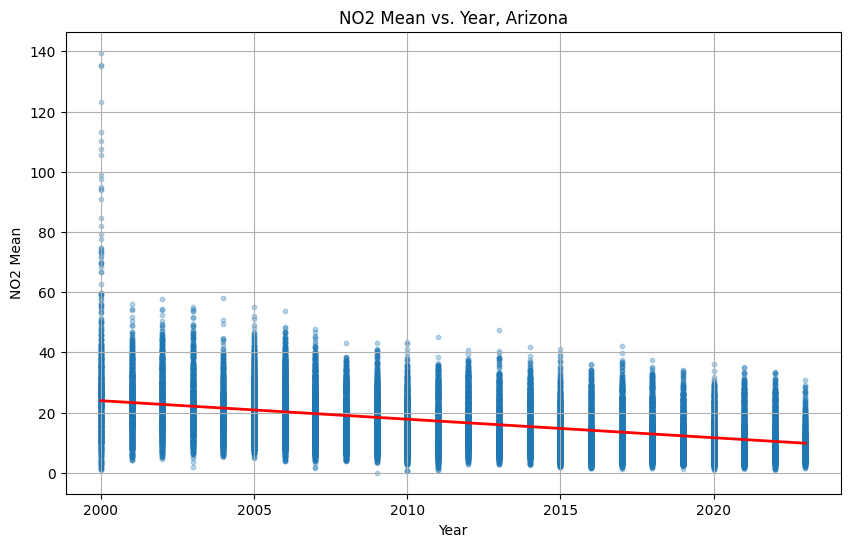

Slope of the regression line: -0.614528
P-value: 0.0000
R-squared: 0.1784


In [ ]:
# Create a regression plot
plt.figure(figsize=(10, 6))
sns.regplot(data=aqdfAZ, x='year', y='NO2 Mean',
            scatter_kws={'alpha': 0.3, 's': 10}, # Adjust alpha and size for points
            line_kws={'color': 'red', 'linewidth': 2}) # Set line color and width
plt.title('NO2 Mean vs. Year, Arizona')
plt.xlabel('Year')
plt.ylabel('NO2 Mean')
plt.grid(True)
plt.show()

# Calculate the slope of the regression line
slope, intercept, r_value, p_value, std_err = stats.linregress(aqdfAZ['year'], aqdfAZ['NO2 Mean'])

print(f"Slope of the regression line: {slope:.6f}")
print(f"P-value: {p_value:.4f}")
print(f"R-squared: {r_value**2:.4f}")

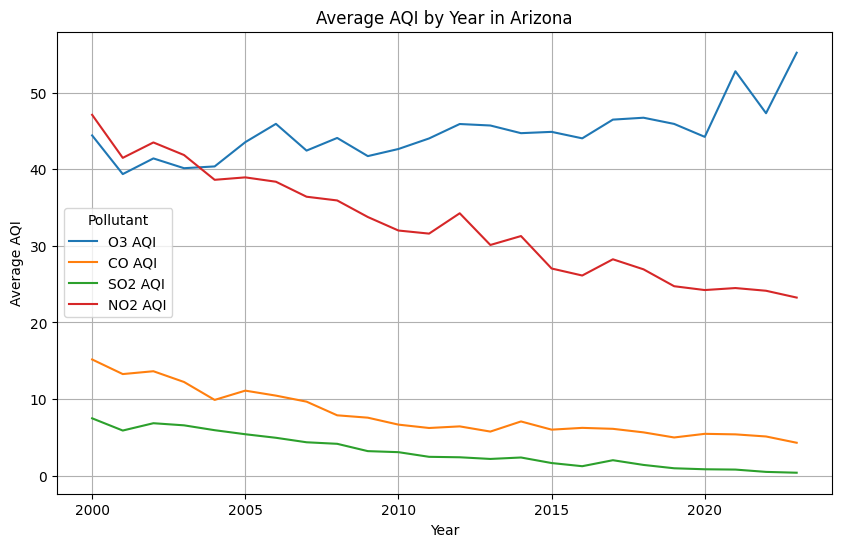

In [ ]:
means = aqdfAZ.groupby('year')[['O3 AQI', 'CO AQI', 'SO2 AQI', 'NO2 AQI']].mean()
means.plot(figsize=(10,6), grid=True,
           xlabel='Year', ylabel='Average AQI',
           title='Average AQI by Year in Arizona')
plt.legend(title='Pollutant')
plt.show()

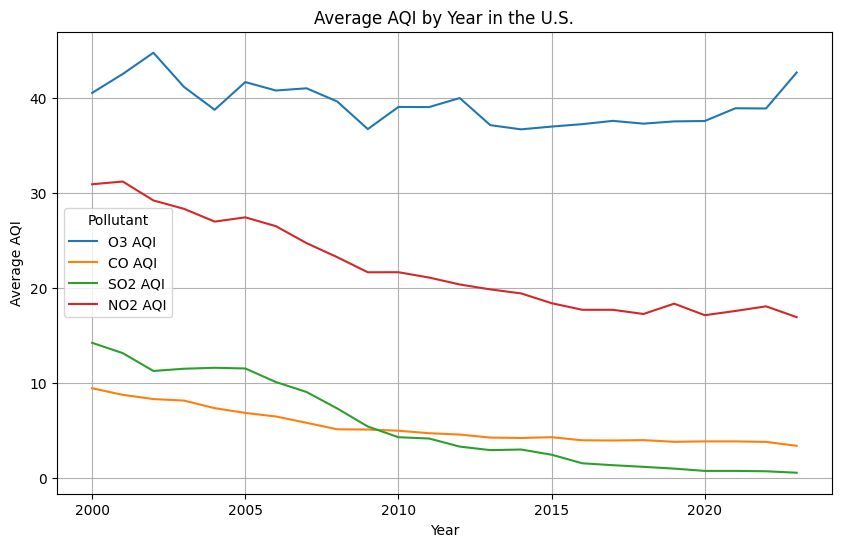

In [ ]:
means = aqdf.groupby('year')[['O3 AQI', 'CO AQI', 'SO2 AQI', 'NO2 AQI']].mean()
means.plot(figsize=(10,6), grid=True,
           xlabel='Year', ylabel='Average AQI',
           title='Average AQI by Year in the U.S.')
plt.legend(title='Pollutant')
plt.show()

In [ ]:
from scipy import stats
import pandas as pd
# Define the split date
split_date = pd.to_datetime('2004-01-24')

# Split the data into two periods
before_split_df = aqdf[aqdf['Date'] < split_date].copy()
after_split_df = aqdf[aqdf['Date'] >= split_date].copy()

# Perform linear regression for the period before the split date
if not before_split_df.empty:
    slope_before, intercept_before, r_value_before, p_value_before, std_err_before = stats.linregress(before_split_df['year'], before_split_df['CO Mean'])
    print(f"Linear regression results for CO Mean before {split_date.date()}:")
    print(f"  Slope: {slope_before:.6f}")
    print(f"  P-value: {p_value_before:.4f}")
    print(f"  R-squared: {r_value_before**2:.4f}")
else:
    print(f"No data available before {split_date.date()} to perform regression.")
    slope_before = None

print("\n" + "="*50 + "\n")

# Perform linear regression for the period after the split date
if not after_split_df.empty:
    slope_after, intercept_after, r_value_after, p_value_after, std_err_after = stats.linregress(after_split_df['year'], after_split_df['CO Mean'])
    print(f"Linear regression results for CO Mean after {split_date.date()}:")
    print(f"  Slope: {slope_after:.6f}")
    print(f"  P-value: {p_value_after:.4f}")
    print(f"  R-squared: {r_value_after**2:.4f}")
else:
    print(f"No data available after {split_date.date()} to perform regression.")
    slope_after = None

# Compare the slopes
if slope_before is not None and slope_after is not None:
    slope_change = slope_after - slope_before
    print(f"\nChange in slope of CO Mean rate of change: {slope_change:.6f}")

Linear regression results for CO Mean before 2004-01-24:
  Slope: -0.015481
  P-value: 0.0000
  R-squared: 0.0016


Linear regression results for CO Mean after 2004-01-24:
  Slope: -0.009336
  P-value: 0.0000
  R-squared: 0.0511

Change in slope of CO Mean rate of change: 0.006145


In [ ]:
from scipy import stats

# Assuming 'before_split_df' and 'after_split_df' are already created as in the previous cell

# Perform independent samples t-test on CO Mean
ttest_result = stats.ttest_ind(before_split_df['CO Mean'], after_split_df['CO Mean'], nan_policy='omit')

print(f"Independent Samples T-test results for CO Mean (before vs after {split_date.date()}):")
print(f"  T-statistic: {ttest_result.statistic:.4f}")
print(f"  P-value: {ttest_result.pvalue:.4f}")

# Interpret the results
alpha = 0.05
if ttest_result.pvalue < alpha:
    print("  The difference in CO Mean between the two periods is statistically significant.")
else:
    print("  The difference in CO Mean between the two periods is not statistically significant.")

Independent Samples T-test results for CO Mean (before vs after 2004-01-24):
  T-statistic: 233.7780
  P-value: 0.0000
  The difference in CO Mean between the two periods is statistically significant.


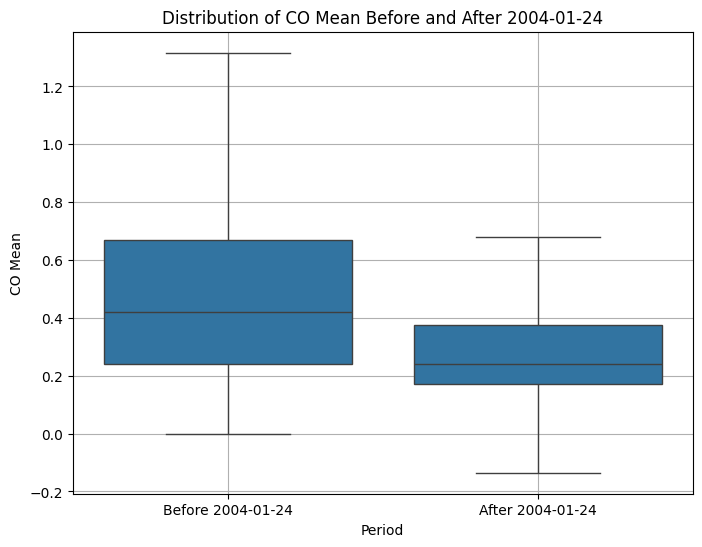

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'aqdf' is already loaded and 'Date' column is in datetime format
# Define the split date
split_date = pd.to_datetime('2004-01-24')

# Create a new column to indicate the period
aqdf['Period'] = aqdf['Date'].apply(lambda x: f'Before {split_date.date()}' if x < split_date else f'After {split_date.date()}')

# Create a box plot
plt.figure(figsize=(8, 6))
sns.boxplot(data=aqdf, x='Period', y='CO Mean', showfliers=False)
plt.title('Distribution of CO Mean Before and After 2004-01-24')
plt.xlabel('Period')
plt.ylabel('CO Mean')
plt.grid(True)
plt.show()

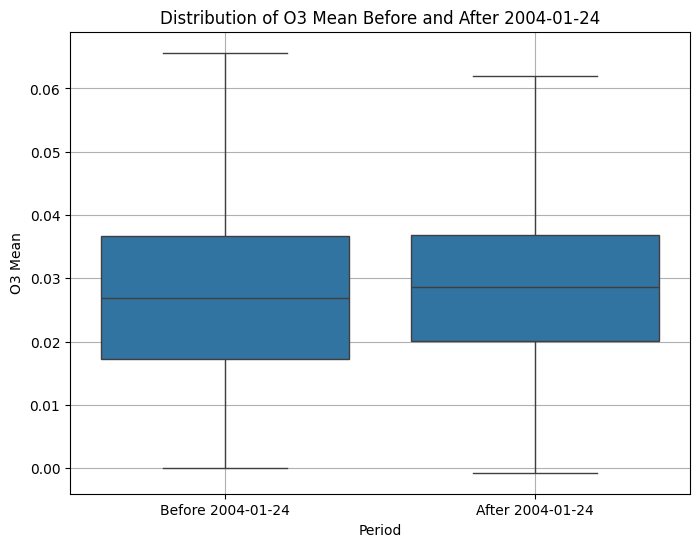

In [ ]:
split_date = pd.to_datetime('2004-01-24')

# Create a new column to indicate the period
aqdf['Period'] = aqdf['Date'].apply(lambda x: f'Before {split_date.date()}' if x < split_date else f'After {split_date.date()}')

# Create a box plot
plt.figure(figsize=(8, 6))
sns.boxplot(data=aqdf, x='Period', y='O3 Mean', showfliers=False)
plt.title('Distribution of O3 Mean Before and After 2004-01-24')
plt.xlabel('Period')
plt.ylabel('O3 Mean')
plt.grid(True)
plt.show()

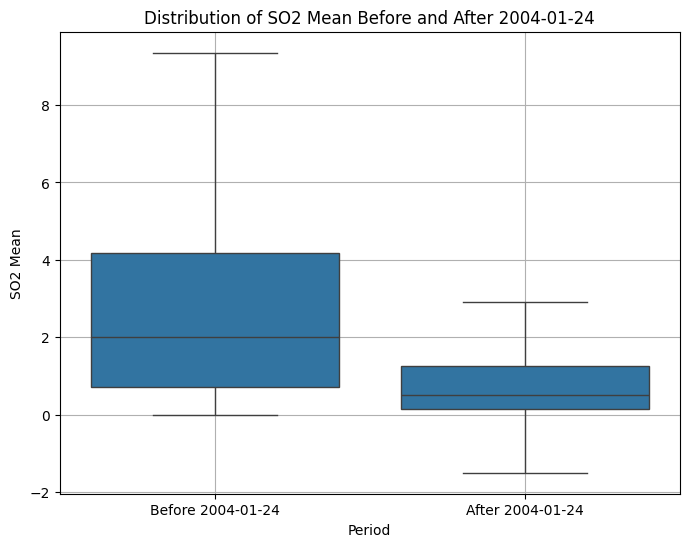

In [ ]:
split_date = pd.to_datetime('2004-01-24')

# Create a new column to indicate the period
aqdf['Period'] = aqdf['Date'].apply(lambda x: f'Before {split_date.date()}' if x < split_date else f'After {split_date.date()}')

# Create a box plot
plt.figure(figsize=(8, 6))
sns.boxplot(data=aqdf, x='Period', y='SO2 Mean', showfliers=False)
plt.title('Distribution of SO2 Mean Before and After 2004-01-24')
plt.xlabel('Period')
plt.ylabel('SO2 Mean')
plt.grid(True)
plt.show()

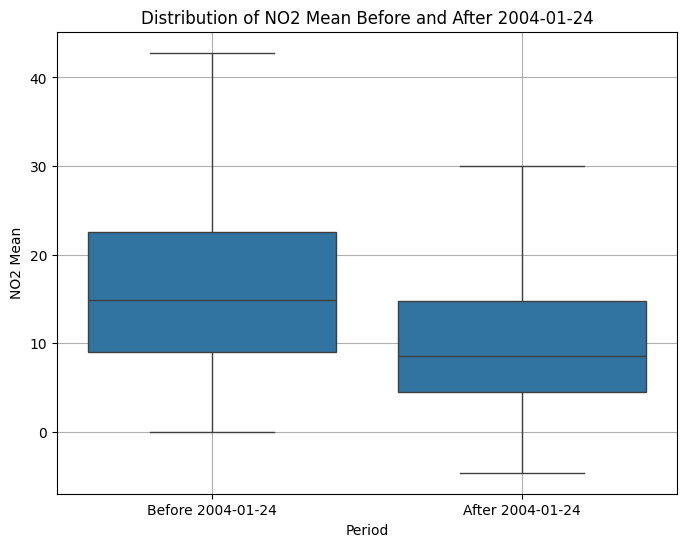

In [ ]:
split_date = pd.to_datetime('2004-01-24')

# Create a new column to indicate the period
aqdf['Period'] = aqdf['Date'].apply(lambda x: f'Before {split_date.date()}' if x < split_date else f'After {split_date.date()}')

# Create a box plot
plt.figure(figsize=(8, 6))
sns.boxplot(data=aqdf, x='Period', y='NO2 Mean', showfliers=False)
plt.title('Distribution of NO2 Mean Before and After 2004-01-24')
plt.xlabel('Period')
plt.ylabel('NO2 Mean')
plt.grid(True)
plt.show()

/tmp/ipython-input-358636911.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aqdfAZ['Date'] = pd.to_datetime(aqdfAZ['Date'])
/tmp/ipython-input-358636911.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aqdfAZ['Period'] = aqdfAZ['Date'].apply(lambda x: f'Before {split_date.date()}' if x < split_date else f'After {split_date.date()}')


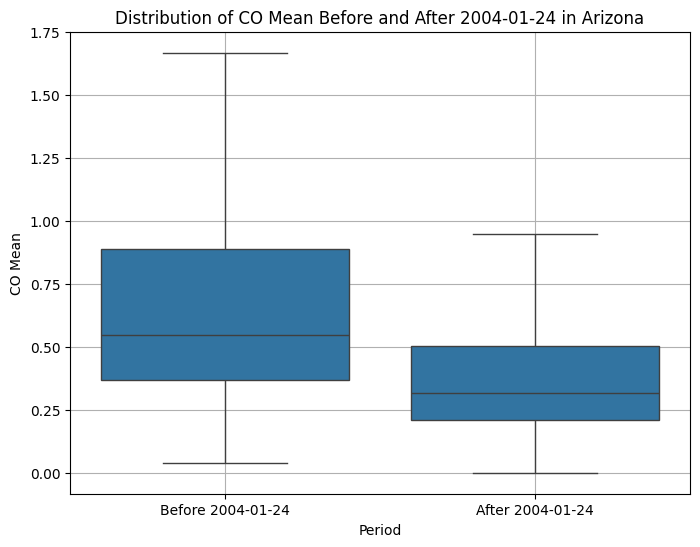

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'aqdfAZ' is already loaded and 'Date' column is in datetime format
# Define the split date
split_date = pd.to_datetime('2004-01-24')

# Ensure the 'Date' column in aqdfAZ is in datetime format
aqdfAZ['Date'] = pd.to_datetime(aqdfAZ['Date'])

# Create a new column to indicate the period for Arizona data
aqdfAZ['Period'] = aqdfAZ['Date'].apply(lambda x: f'Before {split_date.date()}' if x < split_date else f'After {split_date.date()}')

# Create a box plot for CO Mean in Arizona
plt.figure(figsize=(8, 6))
sns.boxplot(data=aqdfAZ, x='Period', y='CO Mean', showfliers=False) # showfliers=False to hide outliers for better visualization of the main distribution
plt.title('Distribution of CO Mean Before and After 2004-01-24 in Arizona')
plt.xlabel('Period')
plt.ylabel('CO Mean')
plt.grid(True)
plt.show()

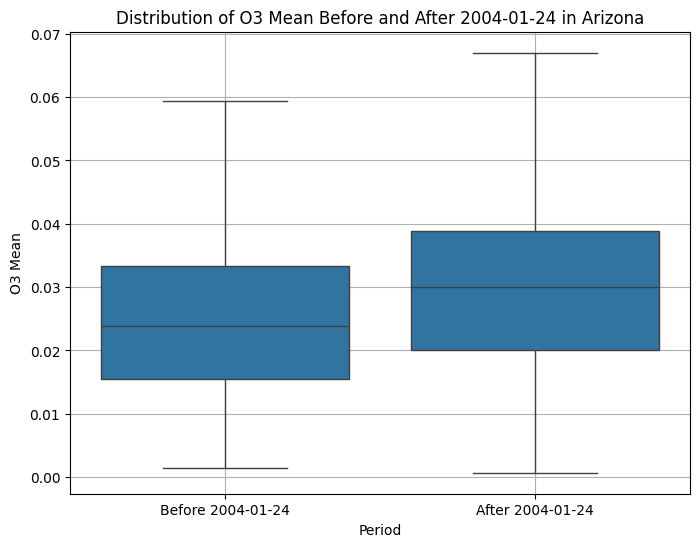

In [ ]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=aqdfAZ, x='Period', y='O3 Mean', showfliers=False) # showfliers=False to hide outliers for better visualization of the main distribution
plt.title('Distribution of O3 Mean Before and After 2004-01-24 in Arizona')
plt.xlabel('Period')
plt.ylabel('O3 Mean')
plt.grid(True)
plt.show()

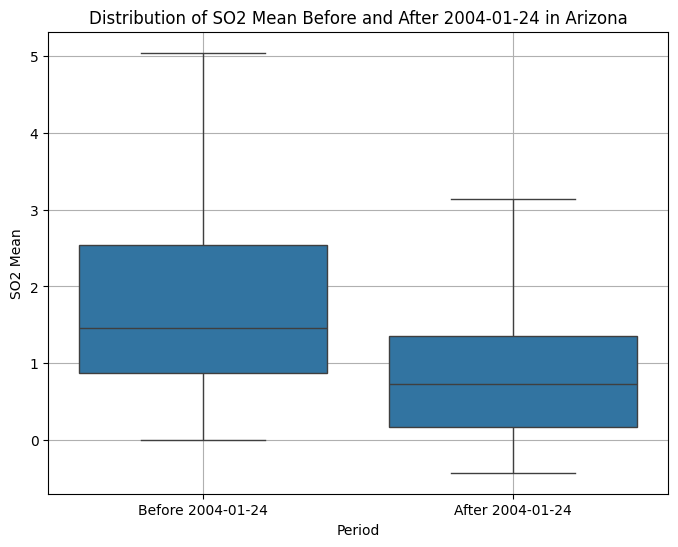

In [ ]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=aqdfAZ, x='Period', y='SO2 Mean', showfliers=False) # showfliers=False to hide outliers for better visualization of the main distribution
plt.title('Distribution of SO2 Mean Before and After 2004-01-24 in Arizona')
plt.xlabel('Period')
plt.ylabel('SO2 Mean')
plt.grid(True)
plt.show()

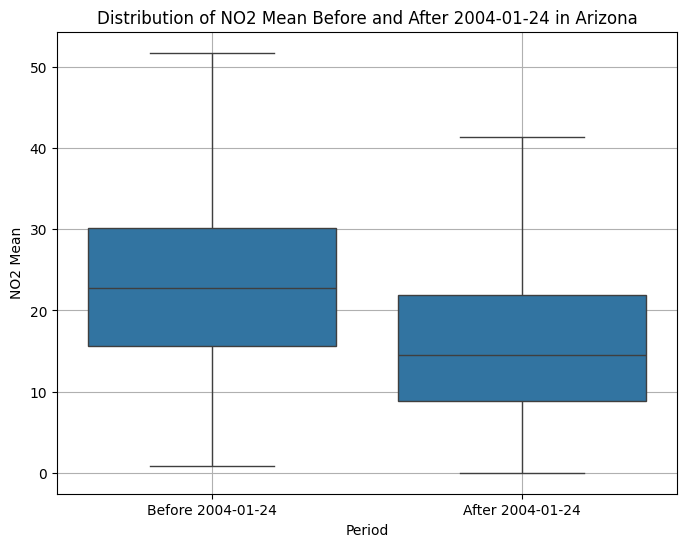

In [ ]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=aqdfAZ, x='Period', y='NO2 Mean', showfliers=False) # showfliers=False to hide outliers for better visualization of the main distribution
plt.title('Distribution of NO2 Mean Before and After 2004-01-24 in Arizona')
plt.xlabel('Period')
plt.ylabel('NO2 Mean')
plt.grid(True)
plt.show()

In [ ]:
ttest_result = stats.ttest_ind(before_split_df['CO Mean'], after_split_df['CO Mean'], nan_policy='omit')

print(f"Independent Samples T-test results for CO Mean (before vs after {split_date.date()}):")
print(f"  T-statistic: {ttest_result.statistic:.4f}")
print(f"  P-value: {ttest_result.pvalue:.4f}")

# Interpret the results
alpha = 0.05
if ttest_result.pvalue < alpha:
    print("  The difference in CO Mean between the two periods is statistically significant.")
else:
    print("  The difference in CO Mean between the two periods is not statistically significant.")

Independent Samples T-test results for CO Mean (before vs after 2004-01-24):
  T-statistic: 233.7780
  P-value: 0.0000
  The difference in CO Mean between the two periods is statistically significant.


In [ ]:
ttest_result = stats.ttest_ind(before_split_df['O3 Mean'], after_split_df['O3 Mean'], nan_policy='omit')

print(f"Independent Samples T-test results for O3 Mean (before vs after {split_date.date()}):")
print(f"  T-statistic: {ttest_result.statistic:.4f}")
print(f"  P-value: {ttest_result.pvalue:.4f}")

# Interpret the results
alpha = 0.05
if ttest_result.pvalue < alpha:
    print("  The difference in O3 Mean between the two periods is statistically significant.")
else:
    print("  The difference in O3 Mean between the two periods is not statistically significant.")

Independent Samples T-test results for O3 Mean (before vs after 2004-01-24):
  T-statistic: -27.3109
  P-value: 0.0000
  The difference in O3 Mean between the two periods is statistically significant.


In [ ]:
ttest_result = stats.ttest_ind(before_split_df['SO2 Mean'], after_split_df['SO2 Mean'], nan_policy='omit')

print(f"Independent Samples T-test results for SO2 Mean (before vs after {split_date.date()}):")
print(f"  T-statistic: {ttest_result.statistic:.4f}")
print(f"  P-value: {ttest_result.pvalue:.4f}")

# Interpret the results
alpha = 0.05
if ttest_result.pvalue < alpha:
    print("  The difference in SO2 Mean between the two periods is statistically significant.")
else:
    print("  The difference in SO2 Mean between the two periods is not statistically significant.")

Independent Samples T-test results for SO2 Mean (before vs after 2004-01-24):
  T-statistic: 248.3366
  P-value: 0.0000
  The difference in SO2 Mean between the two periods is statistically significant.


In [ ]:
ttest_result = stats.ttest_ind(before_split_df['NO2 Mean'], after_split_df['NO2 Mean'], nan_policy='omit')

print(f"Independent Samples T-test results for NO2 Mean (before vs after {split_date.date()}):")
print(f"  T-statistic: {ttest_result.statistic:.4f}")
print(f"  P-value: {ttest_result.pvalue:.4f}")

# Interpret the results
alpha = 0.05
if ttest_result.pvalue < alpha:
    print("  The difference in NO2 Mean between the two periods is statistically significant.")
else:
    print("  The difference in NO2 Mean between the two periods is not statistically significant.")

Independent Samples T-test results for NO2 Mean (before vs after 2004-01-24):
  T-statistic: 203.9854
  P-value: 0.0000
  The difference in NO2 Mean between the two periods is statistically significant.


In [ ]:
before_split_dfAZ = aqdfAZ[aqdfAZ['Date'] < split_date].copy()
after_split_dfAZ = aqdfAZ[aqdfAZ['Date'] >= split_date].copy()

ttest_result = stats.ttest_ind(before_split_dfAZ['CO Mean'], after_split_dfAZ['CO Mean'], nan_policy='omit')

print(f"Independent Samples T-test results for CO Mean (before vs after {split_date.date()}) in Arizona:")
print(f"  T-statistic: {ttest_result.statistic:.4f}")
print(f"  P-value: {ttest_result.pvalue:.4f}")

# Interpret the results
alpha = 0.05
if ttest_result.pvalue < alpha:
    print("  The difference in CO Mean between the two periods is statistically significant.")
else:
    print("  The difference in CO Mean between the two periods is not statistically significant.")

Independent Samples T-test results for CO Mean (before vs after 2004-01-24) in Arizona:
  T-statistic: 53.0186
  P-value: 0.0000
  The difference in CO Mean between the two periods is statistically significant.


In [ ]:
ttest_result = stats.ttest_ind(before_split_dfAZ['O3 Mean'], after_split_dfAZ['O3 Mean'], nan_policy='omit')

print(f"Independent Samples T-test results for O3 Mean (before vs after {split_date.date()}) in Arizona:")
print(f"  T-statistic: {ttest_result.statistic:.4f}")
print(f"  P-value: {ttest_result.pvalue:.4f}")

# Interpret the results
alpha = 0.05
if ttest_result.pvalue < alpha:
    print("  The difference in O3 Mean between the two periods is statistically significant.")
else:
    print("  The difference in O3 Mean between the two periods is not statistically significant.")

Independent Samples T-test results for O3 Mean (before vs after 2004-01-24) in Arizona:
  T-statistic: -22.5504
  P-value: 0.0000
  The difference in O3 Mean between the two periods is statistically significant.


In [ ]:
ttest_result = stats.ttest_ind(before_split_dfAZ['SO2 Mean'], after_split_dfAZ['SO2 Mean'], nan_policy='omit')

print(f"Independent Samples T-test results for SO2 Mean (before vs after {split_date.date()}) in Arizona:")
print(f"  T-statistic: {ttest_result.statistic:.4f}")
print(f"  P-value: {ttest_result.pvalue:.4f}")

# Interpret the results
alpha = 0.05
if ttest_result.pvalue < alpha:
    print("  The difference in SO2 Mean between the two periods is statistically significant.")
else:
    print("  The difference in SO2 Mean between the two periods is not statistically significant.")

Independent Samples T-test results for SO2 Mean (before vs after 2004-01-24) in Arizona:
  T-statistic: 49.1043
  P-value: 0.0000
  The difference in SO2 Mean between the two periods is statistically significant.


In [ ]:
ttest_result = stats.ttest_ind(before_split_dfAZ['NO2 Mean'], after_split_dfAZ['NO2 Mean'], nan_policy='omit')

print(f"Independent Samples T-test results for NO2 Mean (before vs after {split_date.date()}) in Arizona:")
print(f"  T-statistic: {ttest_result.statistic:.4f}")
print(f"  P-value: {ttest_result.pvalue:.4f}")

# Interpret the results
alpha = 0.05
if ttest_result.pvalue < alpha:
    print("  The difference in NO2 Mean between the two periods is statistically significant.")
else:
    print("  The difference in NO2 Mean between the two periods is not statistically significant.")

Independent Samples T-test results for NO2 Mean (before vs after 2004-01-24) in Arizona:
  T-statistic: 49.0884
  P-value: 0.0000
  The difference in NO2 Mean between the two periods is statistically significant.
